In [1]:
%matplotlib inline
import torch
import random
import pandas as pd
import numpy as np
import pandas_datareader.data as web
from matplotlib import pyplot
import seaborn as sns
import os

#Plotting 
from pandas.plotting import scatter_matrix

#Libraries for Statistical Models
import statsmodels.api as sm

#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_columns = None
pd.options.display.expand_frame_repr = False
pd.options.display.float_format = '{:.3f}'.format

torch.seed = 42
random.seed(42)
np.random.seed(42)

%run 'nb_utils.ipynb'
task_name = get_filename_of_ipynb()
print(task_name)
data_dir = f'{os.getcwd()}/data/'
log_dir_base = f'{os.getcwd()}/runs/{task_name}'
log_dir = log_dir_base
print(f'{data_dir}\n{log_dir}')

return_period = 5
pct_threshold = 0.05

StockPCTLabelPredictLSTM
/mnt/AIWorkSpace/work/fin-ml/data/
/mnt/AIWorkSpace/work/fin-ml/runs/StockPCTLabelPredictLSTM


In [2]:
# hyperparameters turning
from ray import tune, train, ray
from ray.tune.schedulers import ASHAScheduler

ray.init(log_to_driver=False)

2024-01-30 14:52:07,660	INFO worker.py:1715 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


Python version:,3.8.18
Ray version:,2.9.1
Dashboard:,http://127.0.0.1:8265


In [3]:
from datetime import datetime
import yfinance as yfin

# Loading the data
stk_tickers = [
    "AAPL",
    "MSFT",
    "AMZN",
    "NVDA",
    "GOOGL",
    "TSLA",
    "META",
    "GOOG",
    "ADBE",
    "NFLX",
    "CSCO",
    "INTC",
    "INTU",
    "CMCSA",
    "TXN",
    "AMAT",
    "ADSK",
    "AMD",
    "QCOM",
    "MU",
]

start = datetime(2014, 1, 1)
end = datetime(2023, 12, 31)

ticks_data = []
for stk_symbol in stk_tickers:
    stk_file = f"{data_dir}{stk_symbol}.csv"
    bLoad = False
    if os.path.isfile(stk_file):
        try:
            _stk_data = pd.read_csv(stk_file).set_index("Date")
            bLoad = True
            print(f"read {stk_file} completely!")
        except:
            None
    if bLoad == False:
        # _stk_data = web.get_data_yahoo(stk_tickers, start, end)
        _stk_data = yfin.download([stk_symbol], start, end).dropna()
        _stk_data.to_csv(stk_file)
        print(f"download {stk_symbol} from yfin and write to {stk_file} completely!")
    ticks_data.append(_stk_data)

print(ticks_data)

read /mnt/AIWorkSpace/work/fin-ml/data/AAPL.csv completely!
read /mnt/AIWorkSpace/work/fin-ml/data/MSFT.csv completely!
read /mnt/AIWorkSpace/work/fin-ml/data/AMZN.csv completely!
read /mnt/AIWorkSpace/work/fin-ml/data/NVDA.csv completely!
read /mnt/AIWorkSpace/work/fin-ml/data/GOOGL.csv completely!
read /mnt/AIWorkSpace/work/fin-ml/data/TSLA.csv completely!
read /mnt/AIWorkSpace/work/fin-ml/data/META.csv completely!
read /mnt/AIWorkSpace/work/fin-ml/data/GOOG.csv completely!
read /mnt/AIWorkSpace/work/fin-ml/data/ADBE.csv completely!
read /mnt/AIWorkSpace/work/fin-ml/data/NFLX.csv completely!
read /mnt/AIWorkSpace/work/fin-ml/data/CSCO.csv completely!
read /mnt/AIWorkSpace/work/fin-ml/data/INTC.csv completely!
read /mnt/AIWorkSpace/work/fin-ml/data/INTU.csv completely!
read /mnt/AIWorkSpace/work/fin-ml/data/CMCSA.csv completely!
read /mnt/AIWorkSpace/work/fin-ml/data/TXN.csv completely!
read /mnt/AIWorkSpace/work/fin-ml/data/AMAT.csv completely!
read /mnt/AIWorkSpace/work/fin-ml/data/

In [4]:
import torch

device_name = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
device = torch.device(device_name)
seq_len = 3
validation_size = 0.2
epoch_num = 100
batch_size = 32
num_workers = 2
pin_memory = True
shuffle = True
print(f"device_name:{device}")

device_name:cuda


In [5]:
def gen_buy_sell_signal(stk_data):
    import pandas_ta as ta

    sma = pd.concat(
        [
            stk_data.ta.sma(close="Adj Close", length=10),
            stk_data.ta.sma(close="Adj Close", length=60),
        ],
        axis=1,
    ).dropna()
    buy_signal = sma["SMA_10"] > sma["SMA_60"]

    buy_sell_signal = stk_data[[]].copy()
    buy_sell_signal["Signal"] = (buy_signal).astype("int")

    return buy_sell_signal


# 0: PCT <= -0.05
# 1: 0.05 < PCT < -0.05
# 2: PCT >= -0.05
def gen_pct_label(stk_data, _return_period):
    pct_data = stk_data["Adj Close"].pct_change(_return_period)
    pct_label = pct_data.apply(
        lambda x: 2 if x >= pct_threshold else 0 if x <= -pct_threshold else 1
    ).astype("int8")
    pct_label.name = "label"
    return pct_label


def gen_analysis_data(stk_data, _return_period):
    import pandas_ta as ta

    data = pd.concat(
        [
            stk_data.ta.adosc(),
            stk_data.ta.kvo(),
            stk_data.ta.rsi(close="Adj Close", length=10) / 100,
            stk_data.ta.rsi(close="Adj Close", length=30) / 100,
            stk_data.ta.rsi(close="Adj Close", length=200) / 100,
            stk_data.ta.stoch(k=10) / 100,
            stk_data.ta.stoch(k=30) / 100,
            stk_data.ta.stoch(k=200) / 100,
            gen_buy_sell_signal(stk_data),
        ],
        axis=1,
    )

    data = pd.concat(
        [data.dropna().astype("float32"), gen_pct_label(stk_data, _return_period)],
        axis=1,
    )
    return data

In [6]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


class LSTMDataSet(Dataset):
    def __init__(self, ticks_data_X, ticks_data_Y, seq_len):
        self.ticks_data_X = ticks_data_X
        self.ticks_data_Y = ticks_data_Y
        self.seq_len = seq_len
        len_array = [len(d) - self.seq_len + 1 for d in ticks_data_X]
        self.idx_boundary = [len_array[0]]

        for i in range(1, len(len_array)):
            self.idx_boundary.append(len_array[i] + self.idx_boundary[i - 1])

    def __len__(self):
        # print(f"len of dataset:{self.idx_boundary[-1]}")
        return self.idx_boundary[-1]  # len(self.X) - self.seq_len + 1

    def __getitem__(self, idx):
        for ticks_data_idx in range(len(self.ticks_data_X)):
            if self.idx_boundary[ticks_data_idx] > idx:
                break
        offset = (
            idx if ticks_data_idx == 0 else idx - self.idx_boundary[ticks_data_idx - 1]
        )
        # print(f"{ticks_data_idx}, {offset}")
        return (
            np.array(self.ticks_data_X[ticks_data_idx][offset : offset + self.seq_len]),
            int(self.ticks_data_Y[ticks_data_idx].iloc[offset + self.seq_len - 1, :]),
        )

In [7]:
import random
import math
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn_pandas import DataFrameMapper


def prepare_dataloader(_return_period):
    ticks_dataset = [gen_analysis_data(d, _return_period) for d in ticks_data]
    ticks_X_train_data = []
    ticks_Y_train_data = []
    ticks_X_test_data = []
    ticks_Y_test_data = []
    ticks_X_dfm = []
    for dataset in ticks_dataset:
        test_size = int(dataset.shape[0] * validation_size)
        # random.seed(42)
        test_data_idx = random.sample(range(0, dataset.shape[0]), test_size)
        mask = np.full(len(dataset), False)
        mask[test_data_idx] = True
        train_data = dataset[~mask]
        test_data = dataset[mask]

        X_train_data = train_data.iloc[:, :-1]
        Y_train_data = train_data.iloc[:, -1:]

        X_test_data = test_data.iloc[:, :-1]
        Y_test_data = test_data.iloc[:, -1:]

        features = [
            ([column], StandardScaler()) for column in X_train_data.columns[:3].values
        ]
        features.extend(
            [([column], None) for column in X_train_data.columns[3:].values]
        )
        # print(features)
        X_dfm = DataFrameMapper(features, input_df=True, df_out=True)
        X_train_data = X_dfm.fit_transform(X_train_data)
        X_test_data = X_dfm.transform(X_test_data)

        ticks_X_dfm.append(X_dfm)
        ticks_X_train_data.append(X_train_data)
        ticks_Y_train_data.append(Y_train_data)
        ticks_X_test_data.append(X_test_data)
        ticks_Y_test_data.append(Y_test_data)

    train_loader = DataLoader(
        LSTMDataSet(ticks_X_train_data, ticks_Y_train_data, seq_len),
        batch_size,
        shuffle=shuffle,
        num_workers=num_workers,
        pin_memory=pin_memory,
        pin_memory_device=device_name,
    )
    test_loader = DataLoader(
        LSTMDataSet(ticks_X_test_data, ticks_Y_test_data, seq_len),
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        pin_memory_device=device_name,
    )

    return train_loader, test_loader, ticks_X_train_data[0].shape[1]

In [8]:
from torch import nn


class StockPCTLabelPredictLSTM(nn.Module):
    def __init__(
        self,
        input_size,
        hidden_size,
        num_layers,
        num_fc_layers,
        activation_type,
    ):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        """
            input_size    : The number of expected features in the input x
            hidden_size   : The number of features in the hidden state h
            num_layers    : Number of recurrent layers. E.g., setting num_layers=2 would mean stacking two LSTMs together to form a stacked LSTM, with the second LSTM taking in outputs of the first LSTM and computing the final results. Default: 1
            bias          : If False, then the layer does not use bias weights b_ih and b_hh. Default: True
            batch_first   : If True, then the input and output tensors are provided as (batch, seq, feature) instead of (seq, batch, feature). Note that this does not apply to hidden or cell states. See the Inputs/Outputs sections below for details. Default: False
            dropout       : If non-zero, introduces a Dropout layer on the outputs of each LSTM layer except the last layer, with dropout probability equal to dropout. Default: 0
            bidirectional : If True, becomes a bidirectional LSTM. Default: False
            proj_size     : If > 0, will use LSTM with projections of corresponding size. Default: 0
        """
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        layers = []
        in_features = self.hidden_size
        for i in range(1, num_fc_layers):
            out_features = int(in_features / 2)
            if out_features <= 3:
                break
            layers.append(nn.Linear(in_features, out_features))
            layers.append(
                nn.ReLU() if activation_type == 1 else nn.Sigmoid()
            ) if activation_type == 2 else nn.Tanh()
            in_features = out_features

        layers.append(nn.Linear(in_features, 3))
        self.fc = nn.Sequential(*layers)
        self.fc.apply(self.init_weights)

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            initrange = 0.5
            nn.init.uniform_(m.weight, -initrange, initrange)
            nn.init.zeros_(m.bias)
            # print(f"{m.in_features},{m.out_features}")

    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_size).to(device)
        c_0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_size).to(device)
        out, (h_out, _) = self.rnn(x, (h_0, c_0))

        fc_input = h_out[-1].view(-1, self.hidden_size)
        return self.fc(fc_input)


def save_model(model, hyper_parameters, file_path, epoch_num=None):
    state = {
        "epoch_num": epoch_num,
        "time": str(datetime.now),
        "model_state": model.state_dict(),
        "input_size": model.input_size,
        "hyper_parameters": hyper_parameters,
    }
    print(f"save model:{file_path}")
    torch.save(state, file_path)


def load_model(file_path):
    data_dict = torch.load(file_path)
    hyper_parameters = data_dict["hyper_parameters"]
    model = StockPCTLabelPredictLSTM(
        input_size=data_dict["input_size"],
        hidden_size=int(hyper_parameters["hidden_size"]),
        num_layers=int(hyper_parameters["num_layers"]),
        num_fc_layers=int(hyper_parameters["num_fc_layers"]),
        activation_type=int(hyper_parameters["activation_type"]),
    )
    model.load_state_dict(data_dict["model_state"])
    return model, hyper_parameters

In [9]:
import math
from sklearn.metrics import mean_squared_error


def eval_dl_method(model, dl, device=device):
    from sklearn.metrics import f1_score

    model.eval()
    y_gt = []
    y_pred = []
    total = 0
    correct = 0
    f1 = 0
    for x, y in dl:
        x = x.to(device)
        y = y.to(device)
        outputs = model(x)
        _, predicted = torch.max(outputs, dim=1)
        total += y.shape[0]
        correct += int((predicted == y).sum())
        # f1 += f1_score(y.cpu().detach(), predicted.cpu().detach())

    accuracy = correct / total
    f1 = f1 / len(dl)
    # print(f"Accuracy: {accuracy:.3f}, F1 score:{f1:.3f}")
    return accuracy, f1

In [13]:
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

import warnings

warnings.filterwarnings("ignore")
_best_loss = 999.0
_best_accuracy = 0.0


def do_train(model, optimizer, train_dl, test_dl, id_str, config, writer=None):
    global _best_loss
    global _best_accuracy

    criterion = torch.nn.CrossEntropyLoss()

    model_name = f"{log_dir}/{id_str}.pt"

    total_loss = 0.0
    total_accuracy = 0.0
    # for epoch in tqdm(range(epoch_num)):
    for epoch in range(epoch_num):
        model.train()
        running_loss = 0.0

        total_size = 0
        total_correct_size = 0
        for i, (x, y) in enumerate(train_dl):
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs, dim=1)
            total_size += y.shape[0]
            total_correct_size += int((predicted == y).sum())

        with torch.no_grad():
            accuracy, f1 = eval_dl_method(model, test_dl)
            if accuracy > _best_accuracy:
                _best_accuracy = accuracy

            if loss.item() < _best_loss:
                _best_loss = loss.item()
                save_model(model, config, model_name)

        total_loss += running_loss / len(train_dl)
        total_accuracy += accuracy

        train.report(
            {
                "loss": running_loss / len(train_dl),
                "train_accuracy": total_correct_size / total_size,
                "mean_accuracy": accuracy,
            }
        )
        if writer != None:
            writer.add_scalars(
                "Training vs. Validation Loss",
                {
                    "loss": running_loss / len(train_dl),
                    "train_accuracy": total_correct_size / total_size,
                    "mean_accuracy": accuracy,
                },
                epoch + 1,
            )
            writer.flush()

    return {
        "Train loss": total_loss / epoch_num,
        "Validation Accuracy": total_accuracy / epoch_num,
    }

In [18]:
def train_LSTM(config, tensorreport=True):
    _return_period = config["return_period"]
    _seq_len = config["seq_len"]
    lr = config["lr"]
    momentum = config["momentum"]
    optim_type = config["optim_type"]
    num_layers = config["num_layers"]
    hidden_size = config["hidden_size"]
    num_fc_layers = config["num_fc_layers"]
    activation_type = config["activation_type"]

    id_str = "_".join(str(v) if v < 1 else f"{v:g}" for v in config.values())
    print(id_str)

    if tensorreport:
        writer = SummaryWriter(f"{log_dir}/{id_str}")
    train_loader, test_loader, features_size = prepare_dataloader(_return_period)
    model = StockPCTLabelPredictLSTM(
        input_size=features_size,
        hidden_size=hidden_size,
        num_layers=num_layers,
        num_fc_layers=num_fc_layers,
        activation_type=activation_type,
    )

    model = model.to(device)
    optimizer = (
        torch.optim.Adam(model.parameters(), lr=lr)
        if optim_type == 1
        else torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    )
    metric_dict = do_train(
        model,
        optimizer,
        train_loader,
        test_loader,
        id_str,
        config,
        writer if tensorreport else None,
    )

    if tensorreport:
        writer.add_hparams(config, metric_dict)
        writer.close()

In [16]:
time_str = datetime.now().strftime("%Y-%m-%d_%H.%M.%S")
log_dir = f"{log_dir_base}/{time_str}"
config = {
    "return_period": 5,
    "seq_len": 10,
    "lr": 0.01,
    "momentum": 0.34936886087152874,
    "optim_type": 2,
    "num_layers": 4,
    "hidden_size": 32,
    "num_fc_layers": 3,
    "activation_type": 1,
}
epoch_num = 20
os.mkdir(log_dir)
print(log_dir)
train_LSTM(config, tensorreport=True)

/mnt/AIWorkSpace/work/fin-ml/runs/StockPCTLabelPredictLSTM/2024-01-30_15.02.22
5_10_0.01_0.34936886087152874_2_4_32_3_1


In [17]:
search_space = {
    "return_period": tune.grid_search([5]),  # [2,3,5,10]
    "seq_len": tune.grid_search([5, 10]),
    "lr": tune.grid_search([0.01]),  # [0.001, 0.01, 0.1]
    "momentum": tune.uniform(0.1, 0.9),
    "optim_type": tune.grid_search([2]),  # [1, 2]
    "num_layers": tune.grid_search([2, 4]),  # , 8, 16]),  # [1, 2, 4, 8]
    "hidden_size": tune.grid_search([32, 64]),  # , 128, 256]),  # [8, 16, 32, 64, 128]
    "num_fc_layers": tune.grid_search([1, 2, 3]),  # 1, 2, 3]),
    "activation_type": tune.grid_search([1]),  # , 2, 3]),  # , 2, 3])
}

turning_parameters = []
total_configs = 1
for k, v in search_space.items():
    if (
        type(v).__name__ == "dict"
        and list(v.keys())[0] == "grid_search"
        and len(list(v.values())[0]) > 1
    ):
        turning_parameters.append(k)
        total_configs *= len(list(v.values())[0])
print(turning_parameters)
print(f"Total count of configs = {total_configs}")

['seq_len', 'num_layers', 'hidden_size', 'num_fc_layers']
Total count of configs = 24


In [19]:
import warnings

warnings.filterwarnings("ignore", category=Warning)

time_str = datetime.now().strftime("%Y-%m-%d_%H.%M.%S")
log_dir = f"{log_dir_base}/{time_str}"
os.mkdir(log_dir)
analysis = tune.run(
    train_LSTM,
    config=search_space,
    resources_per_trial={"cpu": 1, "gpu": 1},
    metric="mean_accuracy",
    mode="max",
)

2024-01-30 15:04:29,417	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Trial name,loss,mean_accuracy,train_accuracy
train_LSTM_ec059_00000,nan,0.0948104,0.102213
train_LSTM_ec059_00001,nan,0.0992016,0.101591


2024-01-30 15:05:29,681	WARNING tune.py:186 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 
2024-01-30 15:05:30,874	INFO tune.py:1042 -- Total run time: 61.46 seconds (60.24 seconds for the tuning loop).
2024-01-30 15:05:30,875	WARNING tune.py:1057 -- Experiment has been interrupted, but the most recent state was saved.
Resume experiment with: tune.run(..., resume=True)
2024-01-30 15:05:30,880	WARNING experiment_analysis.py:193 -- Failed to fetch metrics for 22 trial(s):
- train_LSTM_ec059_00002: FileNotFoundError('Could not fetch metrics for train_LSTM_ec059_00002: both result.json and progress.csv were not found at /home/skchen/ray_results/train_LSTM_2024-01-30_15-04-29/train_LSTM_ec059_00002_2_activation_type=1,hidden_size=32,lr=0.0100,momentum=0.6856,num_fc_layers=2,num_layers=2,optim_type=2,retu_2024-01-30_15-04-29')
- train_LSTM_ec059_0000

In [33]:
accuracy_list = []
trial_list = list(analysis.trial_dataframes.values())
for i, trial in enumerate(trial_list):
    if trial.empty == False:
        d = pd.DataFrame.from_dict(
            {
                "mean_accuracy": trial.describe().loc["mean", "mean_accuracy"],
                "trial_id": trial.loc[0:0, "trial_id"],
            }
        )
    else:
        d = pd.DataFrame.from_dict({"mean_accuracy": [np.NaN], "trial_id": [np.NaN]})
    accuracy_list.append(d)
accuracy_df = pd.concat(accuracy_list)
accuracy_df = accuracy_df.reset_index().loc[:, ["mean_accuracy", "trial_id"]]
print(accuracy_df)

    mean_accuracy     trial_id
0           0.097  aa488_00000
1           0.101  aa488_00001
2           0.101  aa488_00002
3           0.099  aa488_00003
4           0.104  aa488_00004
5           0.102  aa488_00005
6           0.099  aa488_00006
7           0.102  aa488_00007
8           0.103  aa488_00008
9           0.104  aa488_00009
10          0.102  aa488_00010
11          0.097  aa488_00011
12          0.104  aa488_00012
13          0.098  aa488_00013
14          0.101  aa488_00014
15          0.100  aa488_00015
16          0.100  aa488_00016
17          0.101  aa488_00017
18          0.102  aa488_00018
19          0.101  aa488_00019
20          0.101  aa488_00020
21          0.097  aa488_00021
22          0.106  aa488_00022
23          0.102  aa488_00023


In [34]:
import shutil

config_df = pd.DataFrame(analysis.get_all_configs().values())
print(config_df)

results = pd.concat([accuracy_df, config_df], axis=1)
print(results)

sorted_results = results.sort_values(by="mean_accuracy", ascending=False)
print(sorted_results.head(100))
sorted_results_file = f"{task_name}_sorted_results.csv"
sorted_results.to_csv(sorted_results_file)

best_config = config_df.iloc[sorted_results.index[0]]
id_str = "_".join(str(v) if v < 1 else f"{v:g}" for v in best_config.to_list())
best_model_name = f"{log_dir}/{id_str}.pt"
print(best_model_name)
shutil.copy(best_model_name, f"{task_name}.pt")

    return_period  seq_len    lr  momentum  optim_type  num_layers  hidden_size  num_fc_layers  activation_type
0               5        5 0.010     0.465           2           2           32              1                1
1               5        5 0.010     0.728           2           2           64              1                1
2               5        5 0.010     0.260           2           2           32              2                1
3               5        5 0.010     0.511           2           2           64              2                1
4               5        5 0.010     0.574           2           2           32              3                1
5               5        5 0.010     0.137           2           2           64              3                1
6               5        5 0.010     0.586           2           4           32              1                1
7               5        5 0.010     0.236           2           4           64              1          

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/AIWorkSpace/work/fin-ml/runs/StockPCTLabelPredictLSTM/2024-01-30_14.12.32/5_10_0.01_0.34936886087152874_2_4_32_3_1.pt'

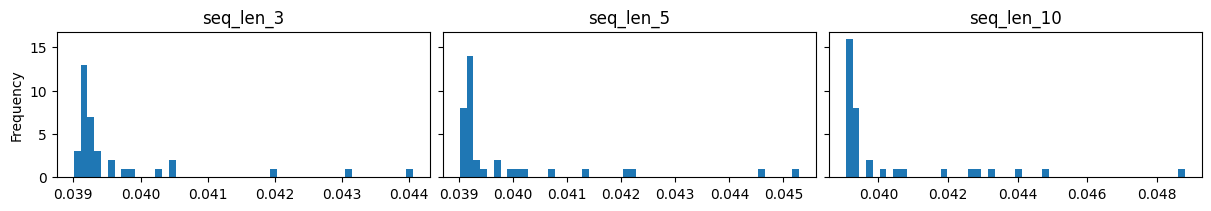

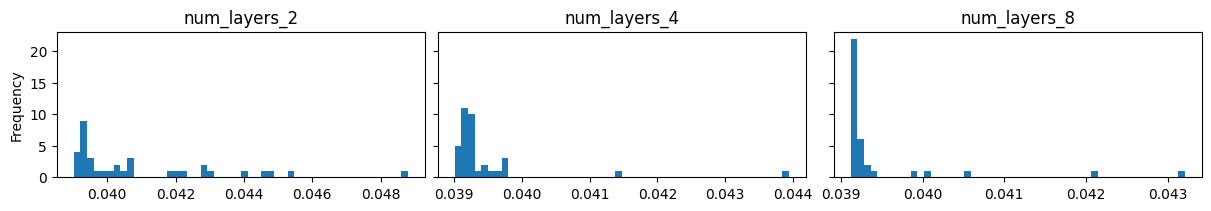

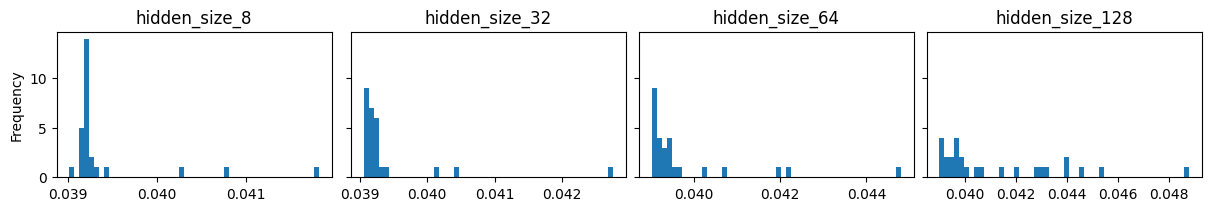

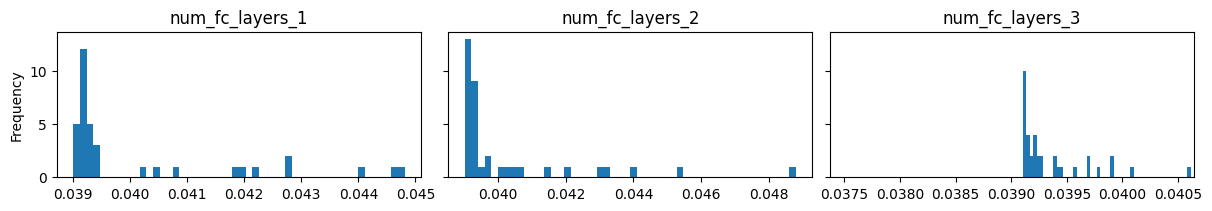

In [24]:
accuracy_desc = sorted_results["mean_accuracy"].astype("float32").describe()
xlimit_range = [
    accuracy_desc["min"] - accuracy_desc["std"],
    accuracy_desc["max"] + accuracy_desc["std"],
]
for hperparameter_name in turning_parameters:
    parameter_group = sorted_results.groupby(hperparameter_name)
    fix, axs = pyplot.subplots(
        1,
        len(parameter_group),
        layout="constrained",
        sharex=False,
        sharey=True,
        figsize=(12, 2),
    )
    for i, g in enumerate(parameter_group):
        g[1]["mean_accuracy"].astype("float32").plot(
            kind="hist", bins=50, subplots=True, sharex=False, sharey=True, ax=axs[i]
        )
        axs[i].set_title(f"{hperparameter_name}_{g[0]}")

pyplot.xlim(xlimit_range)
pyplot.show()

In [10]:
sorted_results_file = f"{task_name}_sorted_results.csv"
sorted_results = pd.read_csv(sorted_results_file, dtype="str")
best_config = sorted_results.loc[0]
print(best_config)
# id_str_of_best = f"5_5_0.01_{best_config.momentum}_{best_config.optim_type}_{best_config.num_layers}_{best_config.hidden_size}_{best_config.num_fc_layers}_{best_config.activation_type}"
# best_model_name = f"/mnt/AIWorkSpace/work/fin-ml/runs/{_TARGET_STK}/{time_str}/{id_str_of_best}.pt"
# print(best_model_name)

Unnamed: 0                          50
mse_score          0.03178376515414065
trial_id                   bf758_00050
return_period                        3
seq_len                              3
lr                                0.01
momentum           0.41067475256907493
optim_type                           2
num_layers                           4
hidden_size                         32
num_fc_layers                        2
activation_type                      3
Name: 0, dtype: object


In [13]:
import math
from sklearn.metrics import mean_squared_error

pd.set_option("display.precision", 5)

model, config = load_model(f"{task_name}.pt")
model.to(device)

train_loader, test_loader, features_size = prepare_dataloader(config["return_period"])
model.eval()

(trainAccuracy, trainF1) = eval_dl_method(model, train_loader, device=device)
(testAccuracy, testF1) = eval_dl_method(model, test_loader, device=device)
print(f"Train Accuracy: {trainAccuracy:.2f}\nTest Accuracy: {testAccuracy:.5f}")
print(f"Train F1: {trainF1:.2f}\nTest F1: {testF1:.5f}")

FileNotFoundError: [Errno 2] No such file or directory: 'StockPCTLabelPredictLSTM.pt'